# Bike Sharing Demand

### [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/overview)

Forecast use of a city bikeshare system

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Part 1 Data Analyses

## 1 Load Data

In [2]:
# Load Data
train_data = pd.read_csv('bike-sharing-demand/train.csv')
test_data = pd.read_csv('bike-sharing-demand/test.csv')

display(train_data)
display(test_data)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


That is to say, there are:
- 10886 samples
- 9 features + 3 results

From 2011-01 to 2012-12, we're given the records of first 19 days of each month and is ordered to predict the results in the rest days of each month.

However, the number of records in train_data don't match 24\*19\*24 = 10944, let's see what happen.

In [3]:
train_datetime = pd.to_datetime(train_data['datetime'])

missing_record = []
for idx, datetime in enumerate(train_datetime):
    if idx == 0: continue
    last_datetime = train_datetime[idx-1]
    gap = datetime.hour - last_datetime.hour
    if not int(gap) == 1 and not int(gap) == -23:
        missing_record.append((last_datetime, datetime))

print('%d Records are missing...' % len(missing_record))

42 Records are missing...


Transfer Datetime to 'Year', 'Month'...

In [4]:
train_data['year'] = [dt.year for dt in train_datetime]
train_data['month'] = [dt.month for dt in train_datetime]
train_data['day'] = [dt.day for dt in train_datetime]
train_data['hour'] = [dt.hour for dt in train_datetime]
train_data.drop('datetime', 1, inplace=True)
display(train_data)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


## 2 Feature Engineering

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null int64
month         10886 non-null int64
day           10886 non-null int64
hour          10886 non-null int64
dtypes: float64(3), int64(12)
memory usage: 1.2 MB


In [6]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000


Take a look at the labels.

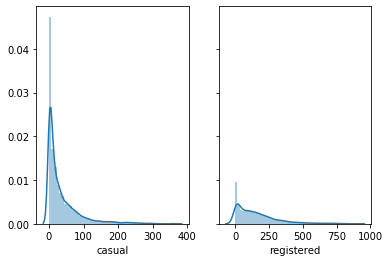

In [7]:
_, axes = plt.subplots(1,2, sharey=True)
sns.distplot(train_data['casual'], ax=axes[0])
sns.distplot(train_data['registered'], ax=axes[1])
plt.show()

As shown above, there're skews in both distributions.

Apply box-cox to normalize them.

In [8]:
train_data['casual'] = np.log(1 + train_data['casual'])
train_data['registered'] = np.log(1 + train_data['registered'])

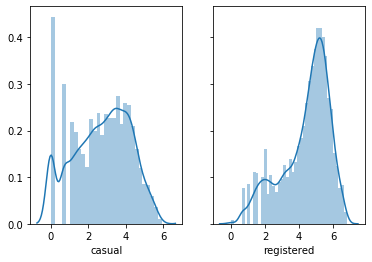

In [9]:
_, axes = plt.subplots(1,2, sharey=True)
sns.distplot(train_data['casual'], ax=axes[0])
sns.distplot(train_data['registered'], ax=axes[1])
plt.show()

In [10]:
features_val_counts = []
for col in train_data.columns:
    features_val_counts.append((col, len(set(train_data[col]))))

print(features_val_counts)

[('season', 4), ('holiday', 2), ('workingday', 2), ('weather', 4), ('temp', 49), ('atemp', 60), ('humidity', 89), ('windspeed', 28), ('casual', 309), ('registered', 731), ('count', 822), ('year', 2), ('month', 12), ('day', 19), ('hour', 24)]


For this result, we know that:

**Discrete Features:**
- season
- holiday
- workingday
- weather

Plot to figure out how these features affect.

**season-casual/register**

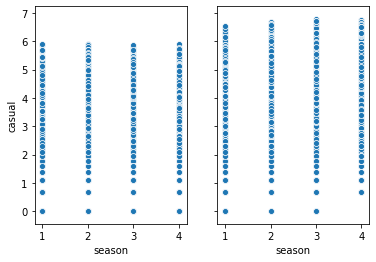

In [11]:
_, axes = plt.subplots(1,2, sharey=True)
sns.scatterplot(x='season', y='casual', data=train_data, ax=axes[0])
sns.scatterplot(x='season', y='registered', data=train_data, ax=axes[1])
plt.show()

**holiday-casual/register**

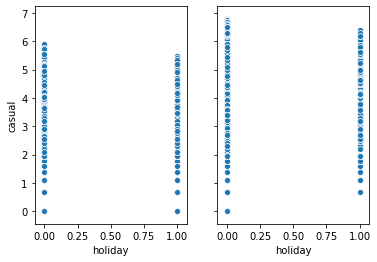

In [12]:
_, axes = plt.subplots(1,2, sharey=True)
sns.scatterplot(x='holiday', y='casual', data=train_data, ax=axes[0])
sns.scatterplot(x='holiday', y='registered', data=train_data, ax=axes[1])
plt.show()

**workingday-casual/register**

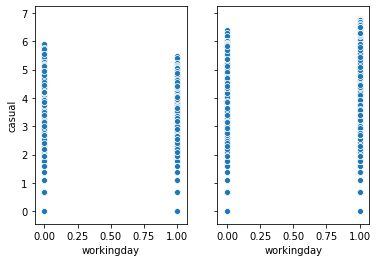

In [13]:
_, axes = plt.subplots(1,2, sharey=True)
sns.scatterplot(x='workingday', y='casual', data=train_data, ax=axes[0])
sns.scatterplot(x='workingday', y='registered', data=train_data, ax=axes[1])
plt.show()

**weather-casual/register**

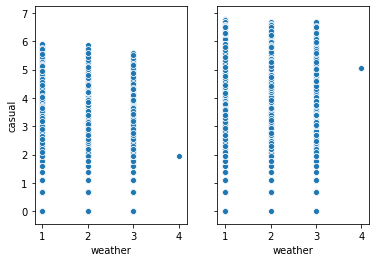

In [14]:
_, axes = plt.subplots(1,2, sharey=True)
sns.scatterplot(x='weather', y='casual', data=train_data, ax=axes[0])
sns.scatterplot(x='weather', y='registered', data=train_data, ax=axes[1])
plt.show()

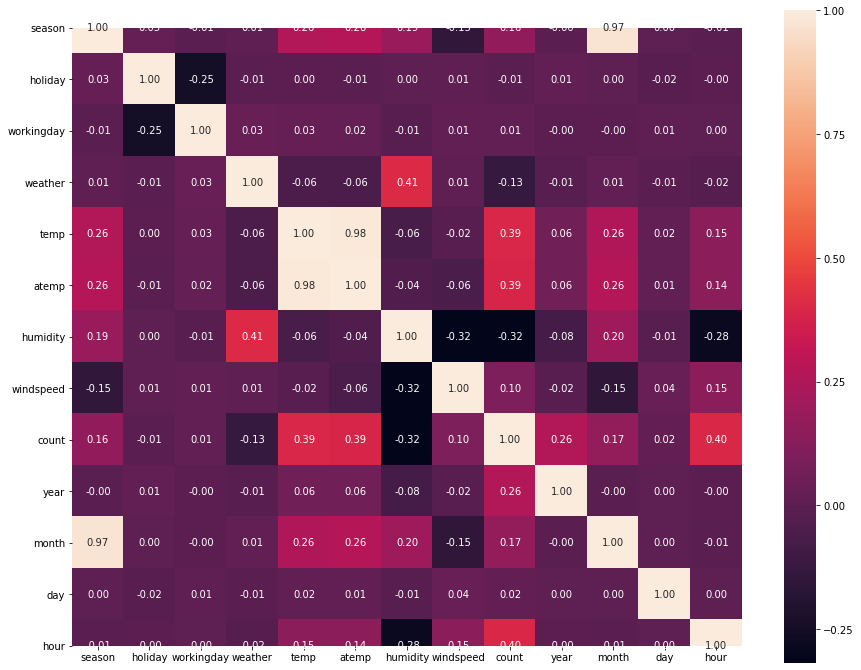

In [15]:
data_corr = train_data.drop(['casual', 'registered'], 1).corr()
plt.subplots(figsize=(15,12))
sns.heatmap(data_corr, square=True,cbar=True, annot=True, fmt='.2f');

From the heatmap, temp and atemp have a coef of 0.98, which means we can only choose one out of these two features, as well as month & season.

Drop 'atemp' and 'month' to get rid of duplicates.

In [16]:
train_data.drop(['atemp', 'month'], 1, inplace=True)

In [17]:
display(train_data)

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,day,hour
0,1,0,0,1,9.84,81,0.0000,1.386294,2.639057,16,2011,1,0
1,1,0,0,1,9.02,80,0.0000,2.197225,3.496508,40,2011,1,1
2,1,0,0,1,9.02,80,0.0000,1.791759,3.332205,32,2011,1,2
3,1,0,0,1,9.84,75,0.0000,1.386294,2.397895,13,2011,1,3
4,1,0,0,1,9.84,75,0.0000,0.000000,0.693147,1,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,2.079442,5.799093,336,2012,19,19
10882,4,0,1,1,14.76,57,15.0013,2.397895,5.446737,241,2012,19,20
10883,4,0,1,1,13.94,61,15.0013,1.609438,5.105945,168,2012,19,21
10884,4,0,1,1,13.94,61,6.0032,2.564949,4.770685,129,2012,19,22


Turn Discrete features into One-Hot encoding.

In [18]:
discrete_features = ['season', 'holiday', 'workingday', 'weather']
for i in discrete_features:
    train_data = pd.concat([train_data, pd.get_dummies(train_data[i], prefix=i)], axis=1, sort=False).drop(i, 1)

In [19]:
display(train_data)

,temp,humidity,windspeed,casual,registered,count,year,day,hour,season_1,...,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
0,9.84,81,0.0000,1.386294,2.639057,16,2011,1,0,1,...,0,0,1,0,1,0,1,0,0,0
1,9.02,80,0.0000,2.197225,3.496508,40,2011,1,1,1,...,0,0,1,0,1,0,1,0,0,0
2,9.02,80,0.0000,1.791759,3.332205,32,2011,1,2,1,...,0,0,1,0,1,0,1,0,0,0
3,9.84,75,0.0000,1.386294,2.397895,13,2011,1,3,1,...,0,0,1,0,1,0,1,0,0,0
4,9.84,75,0.0000,0.000000,0.693147,1,2011,1,4,1,...,0,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,50,26.0027,2.079442,5.799093,336,2012,19,19,0,...,0,1,1,0,0,1,1,0,0,0
10882,14.76,57,15.0013,2.397895,5.446737,241,2012,19,20,0,...,0,1,1,0,0,1,1,0,0,0
10883,13.94,61,15.0013,1.609438,5.105945,168,2012,19,21,0,...,0,1,1,0,0,1,1,0,0,0
10884,13.94,61,6.0032,2.564949,4.770685,129,2012,19,22,0,...,0,1,1,0,0,1,1,0,0,0


## 3 Train the model

First of all, split the dateset.

In [20]:
X_train = train_data.drop(['casual', 'registered', 'count'], 1)
y_train_casual = train_data['casual']
y_train_registered = train_data['registered']
display(X_train.head(3))
display(y_train_casual.head(3))
display(y_train_registered.head(3))

,temp,humidity,windspeed,year,day,hour,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
0,9.84,81,0.0,2011,1,0,1,0,0,0,1,0,1,0,1,0,0,0
1,9.02,80,0.0,2011,1,1,1,0,0,0,1,0,1,0,1,0,0,0
2,9.02,80,0.0,2011,1,2,1,0,0,0,1,0,1,0,1,0,0,0


0    1.386294
1    2.197225
2    1.791759
Name: casual, dtype: float64

0    2.639057
1    3.496508
2    3.332205
Name: registered, dtype: float64

In [21]:
test_datetime = pd.to_datetime(test_data['datetime'])
test_data['year'] = [dt.year for dt in test_datetime]
test_data['month'] = [dt.month for dt in test_datetime]
test_data['day'] = [dt.day for dt in test_datetime]
test_data['hour'] = [dt.hour for dt in test_datetime]
test_data.drop('datetime', 1, inplace=True)
test_data.drop(['atemp', 'month'], 1, inplace=True)
discrete_features = ['season', 'holiday', 'workingday', 'weather']
for i in discrete_features:
    test_data = pd.concat([test_data, pd.get_dummies(test_data[i], prefix=i)], axis=1, sort=False).drop(i, 1)

X_test = test_data
display(X_test)

,temp,humidity,windspeed,year,day,hour,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
0,10.66,56,26.0027,2011,20,0,1,0,0,0,1,0,0,1,1,0,0,0
1,10.66,56,0.0000,2011,20,1,1,0,0,0,1,0,0,1,1,0,0,0
2,10.66,56,0.0000,2011,20,2,1,0,0,0,1,0,0,1,1,0,0,0
3,10.66,56,11.0014,2011,20,3,1,0,0,0,1,0,0,1,1,0,0,0
4,10.66,56,11.0014,2011,20,4,1,0,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,10.66,60,11.0014,2012,31,19,1,0,0,0,1,0,0,1,0,1,0,0
6489,10.66,60,11.0014,2012,31,20,1,0,0,0,1,0,0,1,0,1,0,0
6490,10.66,60,11.0014,2012,31,21,1,0,0,0,1,0,0,1,1,0,0,0
6491,10.66,56,8.9981,2012,31,22,1,0,0,0,1,0,0,1,1,0,0,0


Use RF to build the regression model.

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib

pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))
print(pipeline.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False))], 'verbose': False, 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
           

In [27]:
hyperparameters = {'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                   'randomforestregressor__max_depth': [None, 5, 3, 1],
                   'randomforestregressor__max_leaf_nodes': [None, 2, 5, 7],
                   'randomforestregressor__min_samples_split': [2, 7, 11]}

clf_casual = GridSearchCV(pipeline, hyperparameters, cv=10)
clf_registered = GridSearchCV(pipeline, hyperparameters, cv=10)

# Fit and tune model
clf_casual.fit(X_train, y_train_casual)
clf_registered.fit(X_train, y_train_registered)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split

In [41]:
clf_casual = joblib.load("train_model_casual.m")
clf_registered = joblib.load("train_model_registered.m")

In [42]:
print(clf_casual.best_params_)
print(clf_casual.refit)

print(clf_registered.best_params_)
print(clf_registered.refit)

{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_samples_split': 11}
True
{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_samples_split': 2}
True


In [44]:
prediction_casual = clf_casual.predict(X_train)

print(r2_score(y_train_casual, prediction_casual))
print(mean_squared_error(y_train_casual, prediction_casual))

0.9500904761203316
0.11095089507047963


In [27]:
prediction_registered = clf_registered.predict(X_train)

print(r2_score(y_train_registered, prediction_registered))
print(mean_squared_error(y_train_registered, prediction_registered))

0.9924388655540853
0.014805408204311588


In [28]:
joblib.dump(clf_casual, "train_model_casual.m")
joblib.dump(clf_registered, "train_model_registered.m")

['train_model_registered.m']

In [34]:
prediction_casual = np.exp(clf_casual.predict(X_test)) - 1
prediction_registered = np.exp(clf_registered.predict(X_test)) - 1
prediction = np.int64(prediction_casual + prediction_registered)

test_data = pd.read_csv('bike-sharing-demand/test.csv')
output = pd.DataFrame({'datetime': test_data.datetime, 'count': prediction})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


As an result, I got 0.4156 Score in submission, which ranked about 380 out of 3251.

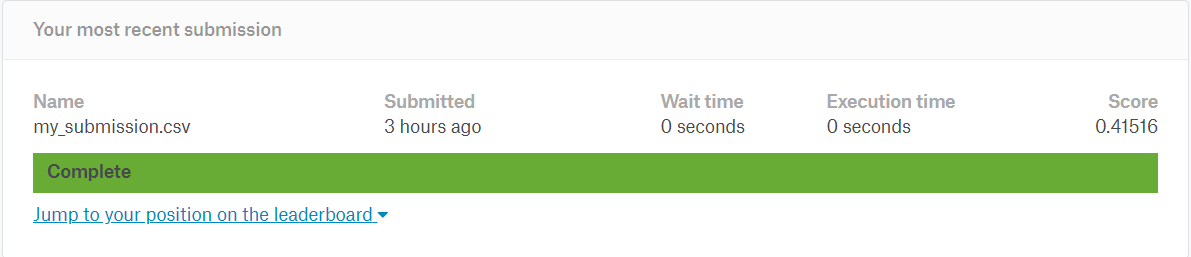